In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import nltk
from nltk.corpus.reader import ConllCorpusReader
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
from sklearn.metrics import classification_report

In [2]:
#Reading data
test_df = pd.read_csv('data/sentiment-topic-test.tsv', delimiter='\t')

train_df = ConllCorpusReader('data/CONLL2003', 'train.txt', ['words', 'pos', 'ignore', 'chunk'])
valid_df = ConllCorpusReader('data/CONLL2003', 'valid.txt', ['words', 'pos', 'ignore', 'chunk'])

In [3]:
#Model Preparation
nltk.download('vader_lexicon')
vader_model = SentimentIntensityAnalyzer()
nlp = spacy.load("en_core_web_sm") # 'en_core_web_sm'

[nltk_data] Downloading package vader_lexicon to C:\Users\Kelvin
[nltk_data]     Brachthuizen\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
def run_vader(textual_unit, 
              lemmatize=False, 
              parts_of_speech_to_consider=None,):
    """
    Run VADER on a sentence from spacy
    
    :param str textual unit: a textual unit, e.g., sentence, sentences (one string)
    (by looping over doc.sents)
    :param bool lemmatize: If True, provide lemmas to VADER instead of words
    :param set parts_of_speech_to_consider:
    -None or empty set: all parts of speech are provided
    -non-empty set: only these parts of speech are considered.
    :param int verbose: if set to 1, information is printed
    about input and output
    
    :rtype: dict
    :return: vader output dict
    """
    doc = nlp(textual_unit)
    input_to_vader = []

    for sentence in doc.sents:
        for token in sentence:
            to_add = token.text

            if lemmatize:
                to_add = token.lemma_ if token.lemma_ != '-PRON-' else token.text

            if not parts_of_speech_to_consider:
                input_to_vader.append(to_add)
                continue
            if token.pos_ in parts_of_speech_to_consider:
                    input_to_vader.append(to_add)

    return vader_model.polarity_scores(' '.join(input_to_vader))

In [5]:
#Begin VADER
def vader_output_to_label(vader_output):
    """
    map vader output e.g.,
    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4215}
    to one of the following values:
    a) positive float -> 'positive'
    b) 0.0 -> 'neutral'
    c) negative float -> 'negative'
    
    :param dict vader_output: output dict from vader
    
    :rtype: str
    :return: 'negative' | 'neutral' | 'positive'
    """
    compound = vader_output['compound']
    
    if compound < 0:
        return 'negative'
    elif compound == 0.0:
        return 'neutral'
    elif compound > 0.0:
        return 'positive'
    
assert vader_output_to_label( {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.0}) == 'neutral'
assert vader_output_to_label( {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.01}) == 'positive'
assert vader_output_to_label( {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': -0.01}) == 'negative'

In [6]:
#Run VADER on the test data
def test_vader(test_set, 
               lemmatize=False, 
               parts_of_speech_to_consider=None):
    """
    Run VADER on a test set
    """ 
    texts = []
    vader_predictions = []
    gold_labels = []

    for index, row in test_set.iterrows():
        text = row['text']
        label = row['sentiment']
        vader_output = run_vader(text, lemmatize=lemmatize, parts_of_speech_to_consider=parts_of_speech_to_consider)
        vader_predictions.append(vader_output_to_label(vader_output))
        gold_labels.append(label)
        texts.append(text)

    #evaluation
    
    print(classification_report(gold_labels, vader_predictions))


In [7]:
test_vader(test_df, lemmatize=True, parts_of_speech_to_consider={'VERB', 'ADJ', 'ADV'})

              precision    recall  f1-score   support

    negative       0.50      0.25      0.33         4
     neutral       0.40      0.67      0.50         3
    positive       0.33      0.33      0.33         3

    accuracy                           0.40        10
   macro avg       0.41      0.42      0.39        10
weighted avg       0.42      0.40      0.38        10



In [8]:
#sklearn imports
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfTransformer

In [9]:
#load training data
train_data = pd.read_csv('data/Kaggle/sentiment-emotion-labelled_Dell_tweets.csv', delimiter=',')
train_data = train_data[['Text', 'sentiment']]

#replace Text by text
train_data.columns = ['text', 'sentiment']

#remove nan values
train_data = train_data.dropna()

#reshape test set
test_df.head()
test_df = test_df[['text', 'sentiment']]

#add test set at the end of training set
all_data = pd.concat([train_data, test_df], ignore_index=True)


In [10]:
train_dict = {'text': [], 'sentiment': []}

#append the text to the corresponding sentiment
for index, row in all_data.iterrows():
    train_dict['text'].append(str(nlp(row['text'])))
    train_dict['sentiment'].append(row['sentiment'])

In [11]:
count_vect = CountVectorizer(min_df=1, # If a token appears fewer times than this, across all documents, it will be ignored
                            tokenizer=nltk.word_tokenize, # we use the nltk tokenizer
                            stop_words=stopwords.words('english')) # stopwords are removed

X_counts = count_vect.fit_transform(train_dict['text'])

train_tfidf_transformer = TfidfTransformer()
X_train_tfidf = train_tfidf_transformer.fit_transform(X_counts)


X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, train_dict['sentiment'], test_size=10, shuffle=False)

clf = MultinomialNB().fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

c:\Users\Kelvin Brachthuizen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Kelvin Brachthuizen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


              precision    recall  f1-score   support

    negative       0.57      1.00      0.73         4
     neutral       0.00      0.00      0.00         3
    positive       1.00      1.00      1.00         3

    accuracy                           0.70        10
   macro avg       0.52      0.67      0.58        10
weighted avg       0.53      0.70      0.59        10



c:\Users\Kelvin Brachthuizen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kelvin Brachthuizen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kelvin Brachthuizen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

Reasoning for using VADER:
- Vader is a rule-based lexicon. (lecture 4, slide 36) This means that, at least on a dataset this small, it is very easy and very fast to use. However, these two properties often go at the cost of performance. For this reason, we wanted to see how it would compare against something that needed more effort and time.
- Lemmatizing helps the model generalize the words used in the test set to something in the VADER lexicon.
- After fine tuning the model using different sets of allowed POS-tagged words, it was found that allowing only verbs, adjectives and adverbs yielded the highest performance.

Reasoning for using Sklearn multinomialNB:
- For sentiment analysis, finding similar training data to that of the providid test set is trivial; The set consists of tweet-like, short text with informal speech.
- Although more complicated, the group had experience in using the model, and could reuse parts of the previously implemented model from Lab3.
- Using the TF-IDF score of the words instead of a normal bag of words representation allows the model to prioritize more prevalent words for the determination of sentiment (very strongly polarizing words might not have a high TF-IDF score, and thus be not that important. They might just be part of normal speech as well). (Lecture 2, slide 57)
- Due to the very small test-set-size, we chose the min_df parameter as small as possible, at 1. This was also confirmed to work best by running the model for different values.

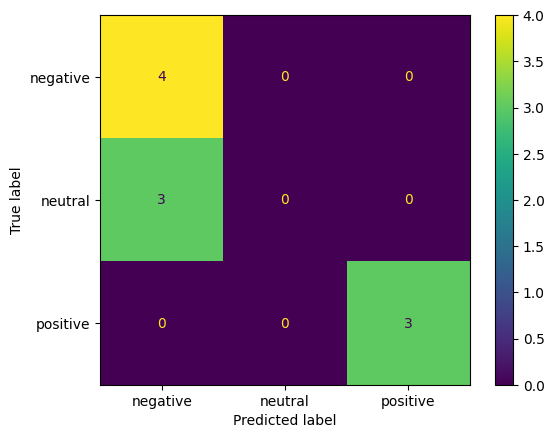

In [12]:
#confusion matirx
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_)
disp.plot()
plt.show()

In [13]:
print(y_test)

['negative', 'neutral', 'positive', 'positive', 'negative', 'neutral', 'negative', 'negative', 'neutral', 'positive']


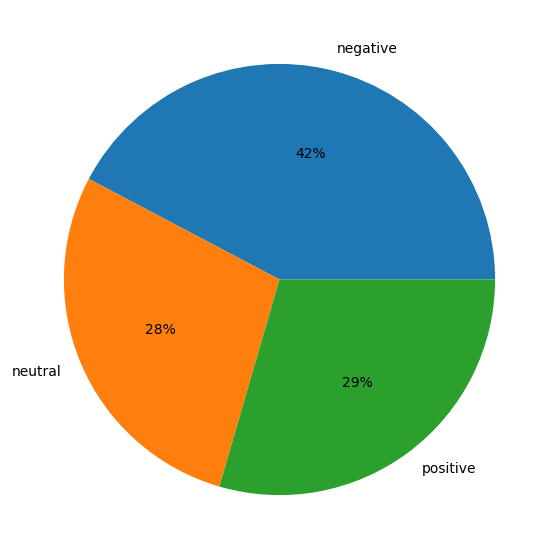

In [14]:
#distribution training data
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10, 7))
plt.pie(clf.class_count_, labels=clf.classes_, autopct='%.0f%%')

plt.show()

In [15]:
print()

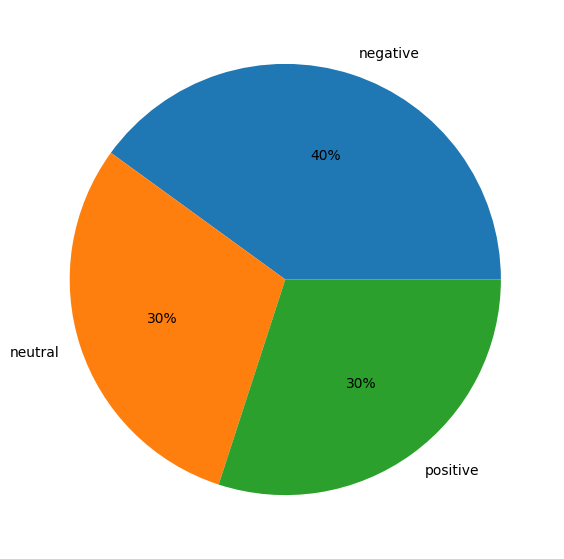

In [16]:
#distribution test data
from matplotlib import pyplot as plt

data_t = []
for sent in clf.classes_:
    data_t.append(len([i for i in y_test if i==sent]))

fig = plt.figure(figsize=(10, 7))
plt.pie(data_t, labels=clf.classes_, autopct='%.0f%%')

plt.show()

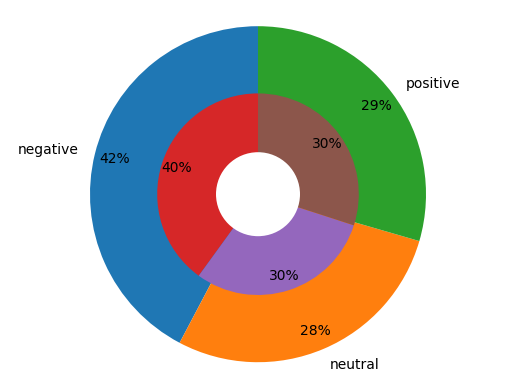

In [17]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

plt.pie(clf.class_count_, labels=clf.classes_, autopct='%.0f%%', startangle=90, pctdistance =0.88, radius= 1.0,) #outer circle train
plt.pie(data_t, autopct='%.0f%%',startangle=90, pctdistance =0.85, radius= 0.60) #inner circle test

centre_circle = plt.Circle((0,0), 0.25, fc='white')
fig= plt.gcf()
fig.gca().add_artist(centre_circle) 

# Plotting the pie 
plt.axis('equal')
plt.show()